# Sensitivity analysis

In [41]:
from SALib.sample import saltelli
from SALib.sample import fast_sampler
from SALib.analyze import sobol
import numpy as np
import pandas as pd
import os
import glob

# function for reading csv files
def pd_read_pattern(pattern, sep):
    files = glob.glob(pattern)
    df = pd.DataFrame()
    for f in files:
        df = df.append(pd.read_csv(f, sep=sep))
    return df.reset_index(drop=True)

# function to remove files
def removeFiles(pattern):
    files = glob.glob(pattern)
    for file in files:
        try:
            os.remove(file)
        except:
            print("Error while deleting file : ", file)
        

In [16]:
# parameter dictionary
problem = {
    'num_vars': 3,
    'names': ['random-mating', 'leakage', 'fertility'],
    'bounds': [[0, 1],
               [0, 0.60],
               [0, 0.30]]
}

# Sobol

In [17]:
param_values = saltelli.sample(problem, 2**10)
t = pd.DataFrame(param_values)
t.columns = ["random-mating", "leakage", "fertility"]
t.to_csv("../models/fertility-BMI/data/param-sobol.csv", index=False)
len(t)

2048

In [71]:
df = pd_read_pattern('../models/fertility-BMI/output/group*.csv', sep=";")
params = pd_read_pattern('../models/fertility-BMI/output/par*.csv', sep=";")
df.iteration = df.iteration.astype(float)
df = df.sort_values(by=['iteration'])
df.to_csv("../output/data/results-sobol.csv", index=False)
Y = df.g4.to_numpy()

In [72]:
Si = sobol.analyze(problem, Y, print_to_console=True)

                     ST   ST_conf
random-mating  0.338787  0.105018
leakage        0.703862  0.132659
fertility      0.499390  0.193034
                     S1   S1_conf
random-mating -0.020798  0.095583
leakage        0.387229  0.183701
fertility      0.241893  0.116106
                                  S2   S2_conf
(random-mating, leakage)    0.252645  0.277094
(random-mating, fertility)  0.068665  0.165005
(leakage, fertility)       -0.057559  0.225275


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

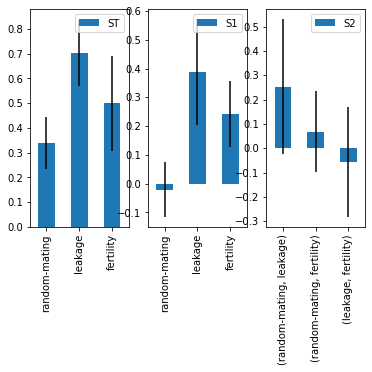

In [91]:
Si.plot()

# EFast

In [87]:
param_values = fast_sampler.sample(problem, 1000)

In [89]:
t = pd.DataFrame(param_values)
t.columns = ["random-mating", "leakage", "fertility"]
t.to_csv("../models/fertility-BMI/data/param-efast.csv", index=False)
len(t)

3000

In [ ]:
df = pd_read_pattern('../models/fertility-BMI/output/group*.csv', sep=";")
params = pd_read_pattern('../models/fertility-BMI/output/par*.csv', sep=";")
df.iteration = df.iteration.astype(float)
df = df.sort_values(by=['iteration'])
df.to_csv("../output/data/results-efast.csv", index=False)
Y = df.g4.to_numpy()

In [ ]:
Sif = fast.analyze(problem, Y, print_to_console=True)